**Machine Learning Final Assignment**

In [1]:
import platform
import sys
import os

print("Python version:", sys.version)
print("Platform:", platform.platform())
print("System:", platform.system(), platform.release())
print("Machine:", platform.machine())
print("Processor:", platform.processor())
print("Environment Variables Sample:")
for k in list(os.environ)[:5]:
    print(f"  {k} = {os.environ[k]}")

Python version: 3.11.12 (main, Apr  9 2025, 08:55:54) [GCC 11.4.0]
Platform: Linux-6.1.123+-x86_64-with-glibc2.35
System: Linux 6.1.123+
Machine: x86_64
Processor: x86_64
Environment Variables Sample:
  SHELL = /bin/bash
  NV_LIBCUBLAS_VERSION = 12.5.3.2-1
  NVIDIA_VISIBLE_DEVICES = all
  COLAB_JUPYTER_TRANSPORT = ipc
  NV_NVML_DEV_VERSION = 12.5.82-1


*Brain Tumor Image Classification
Machine Learning & Deep Learning
16/05/2025*

Part I

In [2]:
# Installing necessary packages
!pip install tensorflow opencv-python imutils prettytable matplotlib pillow h5py kagglehub numpy pandas tensorflow opencv-python scikit-learn scikit-image joblib scikit-optimize sync-batchnorm imagehash

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 13.2 MB/s eta 0:00:00


In [3]:
# Importing necessary libraries
import shutil
import os
import zipfile
import kagglehub
import tensorflow as tf
import numpy as np
import pandas as pd
import h5py
import hashlib
from PIL import Image
from collections import defaultdict
import collections
from prettytable import PrettyTable
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import csv
import random
import pathlib
from pathlib import Path
import cv2
from collections import defaultdict
from glob import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import datasets, layers, models
from tensorflow.keras import Sequential
from tensorflow.keras.regularizers import l2
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, f1_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from joblib import Memory
from sklearn.decomposition import PCA
from skimage.feature import hog
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from sklearn.model_selection import train_test_split

Loading the datasets

In [4]:
import shutil, os
import kagglehub

# Download the main dataset
cache_path = kagglehub.dataset_download("gesp19/ml-final-project-brain-scans")
target_dir = "data"

# Remove existing target directory if it exists
if os.path.exists(target_dir):
    shutil.rmtree(target_dir)

shutil.copytree(cache_path, target_dir)

# Flatten nested "data/data" if exists
inner_data_path = os.path.join(target_dir, "data")
if os.path.exists(inner_data_path) and os.path.isdir(inner_data_path):
    for item in os.listdir(inner_data_path):
        src_path = os.path.join(inner_data_path, item)
        dst_path = os.path.join(target_dir, item)
        if os.path.isdir(src_path):
            shutil.copytree(src_path, dst_path, dirs_exist_ok=True)
        else:
            shutil.copy2(src_path, dst_path)
    shutil.rmtree(inner_data_path)

# Download the additional dataset
cache_path_extra = kagglehub.dataset_download("gesp19/ml-final-project-additional-images")


# Merge additional dataset into 'data'
for item in os.listdir(cache_path_extra):
    src_path = os.path.join(cache_path_extra, item)
    dst_path = os.path.join(target_dir, item)

    if os.path.isdir(src_path):
        os.makedirs(dst_path, exist_ok=True)
        for sub_item in os.listdir(src_path):
            src_subpath = os.path.join(src_path, sub_item)
            dst_subpath = os.path.join(dst_path, sub_item)
            if os.path.isdir(src_subpath):
                shutil.copytree(src_subpath, dst_subpath, dirs_exist_ok=True)
            else:
                shutil.copy2(src_subpath, dst_subpath)
    else:
        shutil.copy2(src_path, dst_path)


print("Both main and additional datasets have been merged into 'data/'")


100%|██████████| 33.1M/33.1M [00:00<00:00, 122MB/s]

Extracting files...


Both main and additional datasets have been merged into 'data/'


**Introduction of the 3 Datasets**

*The 'PMRAM_Dataset' contains two folders: augmented, and raw data. We drop the augmented data folder as they're unecessary for our project.*

In [5]:
shutil.rmtree('data/archive/PMRAM Bangladeshi Brain Cancer - MRI Dataset/PMRAM Bangladeshi Brain Cancer - MRI Dataset/Augmented Data')

In [6]:
# Changing folder structure to make it easier to work with

# Path to folder with actual data
deep_folder = 'data/archive/PMRAM Bangladeshi Brain Cancer - MRI Dataset/PMRAM Bangladeshi Brain Cancer - MRI Dataset/Raw Data/Raw'
new_base = 'data/PMRAM_Dataset'
os.makedirs(new_base, exist_ok=True)

for item in os.listdir(deep_folder): # Moving contents
    src_path = os.path.join(deep_folder, item)
    dst_path = os.path.join(new_base, item)
    shutil.move(src_path, dst_path)

shutil.rmtree('data/archive') # Removing old folder

In [7]:
# Renaming classes of all same name for PMRAM_Dataset
os.rename('data/PMRAM_Dataset/512Glioma', 'data/PMRAM_Dataset/glioma')
os.rename('data/PMRAM_Dataset/512Meningioma', 'data/PMRAM_Dataset/meningioma')
os.rename('data/PMRAM_Dataset/512Pituitary', 'data/PMRAM_Dataset/pituitary')
os.rename('data/PMRAM_Dataset/512Normal', 'data/PMRAM_Dataset/notumor')

*The 'Brain Tumor data' dataset contains instances in .jpg format already, and is already divided in Train-Split. We will be merging these categories and performing a different split. Till then, the duplicated folder is removed and renamed to improve readability*

Converting .mat files into .jpg format

In [8]:
base_folder = 'data/1512427'

input_folders = [
    'brainTumorDataPublic_1-766',
    'brainTumorDataPublic_767-1532',
    'brainTumorDataPublic_1533-2298',
    'brainTumorDataPublic_2299-3064']

output_folder = ('data/China_Dataset')

os.makedirs(output_folder, exist_ok=True)

# Label to class name mapping
label_map = {
    1: 'meningioma',
    2: 'glioma',
    3: 'pituitary'}

for folder_name in input_folders: # Loop through input folders
    input_folder_path = os.path.join(base_folder, folder_name)
    mat_files = [f for f in os.listdir(input_folder_path) if f.endswith('.mat')]

    for mat_file in mat_files:
        mat_file_path = os.path.join(input_folder_path, mat_file)

        # Load .mat file
        with h5py.File(mat_file_path, 'r') as f:
            image = np.array(f['cjdata']['image']).T
            label = int(np.array(f['cjdata']['label'])[0][0])

        # Normalizing image
        image = image.astype(np.float64)
        image = ((image - image.min()) / (image.max() - image.min()) * 255).astype(np.uint8) # Scaling pixel values linearly into 0–255 so they look like a regular 8-bit photo

        # Get class name from label
        class_name = label_map.get(label, 'unknown')
        class_folder = os.path.join(output_folder, class_name)
        os.makedirs(class_folder, exist_ok=True)

        # Save image
        base_name = os.path.splitext(mat_file)[0]
        output_path = os.path.join(class_folder, base_name + '.jpg')
        Image.fromarray(image).save(output_path)

shutil.rmtree('data/1512427') # Removing old folder with .mat files

Merging the train-test folders of the 'Brain Tumor data' dataset

In [9]:
# Merging Brain Tumor data into 4 classes
brain_tumor_base_dir = 'data/Brain Tumor data/Brain Tumor data'
subfolders_to_process = ['Testing', 'Training']
target_directory= 'data/Brain Tumor data'

for source_subfolder_name in subfolders_to_process:
    source_subfolder_path = os.path.join(brain_tumor_base_dir, source_subfolder_name)

    for class_name in os.listdir(source_subfolder_path):
        current_class_source_path = os.path.join(source_subfolder_path, class_name)

        if os.path.isdir(current_class_source_path):
            target_class_path = os.path.join(target_directory, class_name)
            os.makedirs(target_class_path, exist_ok=True)

            for filename in os.listdir(current_class_source_path):
                if filename.lower().endswith('.jpg'):
                    source_file = os.path.join(current_class_source_path, filename)
                    destination_file = os.path.join(target_class_path, filename)

                    shutil.move(source_file, destination_file)

print("\nMerge process complete.")

shutil.rmtree('data/Brain Tumor data/Brain Tumor data')


Merge process complete.


*The 'China_Dataset' appears to be in fairly good condition containing instances in .jpg format. However it is missing one of the four classes' folders*

Adding a "no tumor" subfolder for the dataset to contain all 4 class subfolders

In [10]:
# Creating a new folder so all datasets have all 4 classes
os.makedirs('data/China_Dataset/notumor', exist_ok=True)


**Balancing checks**

*We create a function to check the number of files into each folder and identify possible class imbalances*

In [11]:
def summarize_dataset_distribution(base_dir, canonical_class_names=None):
    if canonical_class_names is None:
        canonical_class_names = ['glioma', 'meningioma', 'pituitary', 'notumor']

    counts = defaultdict(lambda: {c: 0 for c in canonical_class_names})
    dataset_totals = defaultdict(int)
    class_grand_totals = {c: 0 for c in canonical_class_names}

    dataset_names = sorted([d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))])

    if not dataset_names:
        print(f"No dataset folders found in '{base_dir}'.")
        return

    for ds_name in dataset_names:
        current_total = 0
        for class_name in canonical_class_names:
            class_path = os.path.join(base_dir, ds_name, class_name)
            img_count = 0
            if os.path.isdir(class_path):
                img_count = sum(
                    1 for f in os.listdir(class_path)
                    if os.path.isfile(os.path.join(class_path, f)) and f.lower().endswith(('.jpg', '.jpeg', '.png'))
                )
            counts[ds_name][class_name] = img_count
            class_grand_totals[class_name] += img_count
            current_total += img_count
        dataset_totals[ds_name] = current_total

    grand_total = sum(dataset_totals.values())


    table = PrettyTable()
    table.field_names = ["Dataset", "Total"] + canonical_class_names
    table.align = "r"
    table.align["Dataset"] = "l"

    for ds_name in dataset_names:
        row = [ds_name, dataset_totals[ds_name]] + [counts[ds_name][c] for c in canonical_class_names]
        table.add_row(row)

    if grand_total > 0:
        table.add_row(["Total", grand_total] + [class_grand_totals[c] for c in canonical_class_names])
        table.add_row(["% Total", "100.0%"] + [f"{(class_grand_totals[c] / grand_total * 100):.1f}%" for c in canonical_class_names])
    else:
        table.add_row(["Total", 0] + [0] * len(canonical_class_names))
        table.add_row(["% Total", "0.0%"] + ["0.0%"] * len(canonical_class_names))

    print(table)

In [12]:
# Initial Presentation of dataset distribution
summarize_dataset_distribution('data')

+------------------+--------+--------+------------+-----------+---------+
| Dataset          |  Total | glioma | meningioma | pituitary | notumor |
+------------------+--------+--------+------------+-----------+---------+
| AD VS CN Dataset |   2016 |      0 |          0 |         0 |    2016 |
| Brain Tumor data |   7023 |   1621 |       1645 |      1757 |    2000 |
| China_Dataset    |   3064 |   1426 |        708 |       930 |       0 |
| PMRAM_Dataset    |   1505 |    373 |        363 |       373 |     396 |
| Total            |  13608 |   3420 |       2716 |      3060 |    4412 |
| % Total          | 100.0% |  25.1% |      20.0% |     22.5% |   32.4% |
+------------------+--------+--------+------------+-----------+---------+


*Using Hash-1 we remove duplicates*

In [13]:
base_dirs = ['Brain Tumor data', 'China_Dataset', 'PMRAM_Dataset', 'AD VS CN Dataset' ]
base_path = 'data'

hash_map = {}
duplicates = []

def compute_sha1(file_path):
    with open(file_path, 'rb') as f:
        return hashlib.sha1(f.read()).hexdigest()

def get_image_resolution(path):
    try:
        with Image.open(path) as img:
            return img.size[0] * img.size[1]  # width * height
    except:
        return 0

for base_dir in base_dirs:
    full_path = os.path.join(base_path, base_dir)
    for root, _, files in os.walk(full_path):
        for file in files:
            if file.lower().endswith(('.jpg')):
                file_path = os.path.join(root, file)
                hash_val = compute_sha1(file_path)

                if hash_val not in hash_map:
                    hash_map[hash_val] = file_path
                else:
                    current_best = hash_map[hash_val] # If duplicates, gets the one with better resolution
                    if get_image_resolution(file_path) > get_image_resolution(current_best):
                        os.remove(current_best)  # Deletes the other file
                        hash_map[hash_val] = file_path
                    else:
                        os.remove(file_path)  # Deletes the duplicate file
                        duplicates.append([hash_val, file_path, current_best])

In [14]:
import imagehash

base_dirs = ['Brain Tumor data', 'China_Dataset', 'PMRAM_Dataset', 'AD VS CN Dataset']
base_path = 'data'

hash_map = {}
duplicates = []

def compute_sha1(file_path):
    with open(file_path, 'rb') as f:
        return hashlib.sha1(f.read()).hexdigest()

def get_image_resolution(path):
    try:
        with Image.open(path) as img:
            return img.size[0] * img.size[1]  # width * height
    except:
        return 0

for base_dir in base_dirs:
    full_path = os.path.join(base_path, base_dir)
    for root, _, files in os.walk(full_path):
        for file in files:
            if file.lower().endswith(('.jpg')):
                file_path = os.path.join(root, file)
                hash_val = compute_sha1(file_path)

                if hash_val not in hash_map:
                    hash_map[hash_val] = file_path
                else:
                    current_best = hash_map[hash_val] # If duplicates, gets the one with better resolution
                    if get_image_resolution(file_path) > get_image_resolution(current_best):
                        os.remove(current_best)  # Deletes the other file
                        hash_map[hash_val] = file_path
                    else:
                        os.remove(file_path)  # Deletes the duplicate file
                        duplicates.append([hash_val, file_path, current_best])



print("\nStarting perceptual hash deduplication phase...")

phash_threshold = 2  # the lower, the more images are kept
perceptual_duplicates_log = []  # To log pHash based removals: (hash_diff, removed_path, kept_path)


phash_processing_list = [] # Create a list of items to process for pHash
path_to_sha1_map = {v: k for k, v in hash_map.items()}

# Iterate over a copy of hash_map values in case hash_map is modified due to non-existent files
for file_path in list(hash_map.values()):
    if not os.path.exists(file_path):
        # File was likely removed by an external process or an error in previous logic
        # Ensure it's removed from hash_map if it's still listed as the champion for its SHA1
        sha1_val = path_to_sha1_map.get(file_path)
        if sha1_val and hash_map.get(sha1_val) == file_path:
            del hash_map[sha1_val]
        continue
    try:
        img = Image.open(file_path)
        p_hash = imagehash.phash(img)
        resolution = get_image_resolution(file_path) # Using your existing function
        sha1_val = path_to_sha1_map[file_path] # Get SHA1 for this path
        phash_processing_list.append({
            'path': file_path,
            'phash': p_hash,
            'resolution': resolution,
            'sha1': sha1_val
        })
    except Exception as e:
        print(f"Skipping {file_path} for pHash calculation due to error: {e}")
        # If we can't process it, it remains in hash_map unless removed by comparison with another file
        pass

# Sort candidates: e.g., by resolution (desc), then path (asc) for deterministic behavior
phash_processing_list.sort(key=lambda x: (-x['resolution'], x['path']))

# This dictionary will store the items that are kept after pHash comparisons
final_keepers_phash_stage = {}

for current_item_data in phash_processing_list:
    current_path = current_item_data['path']
    current_phash = current_item_data['phash']
    current_resolution = current_item_data['resolution']
    current_sha1 = current_item_data['sha1']

    # If current_path was already removed (ex. it lost a comparison)
    if not os.path.exists(current_path):
        continue

    is_current_item_kept = True # Assume current item is kept unless it loses a comparison

    # Compare current_item_data with items already selected as keepers in final_keepers_phash_stage
    for kept_item_path, kept_item_data in list(final_keepers_phash_stage.items()):

        # If the 'kept_item_path' was somehow removed from disk since being added to keepers (should be rare)
        if not os.path.exists(kept_item_path):
            del final_keepers_phash_stage[kept_item_path]
            continue

        kept_phash_obj = kept_item_data['phash']
        kept_resolution = kept_item_data['resolution']



        try:
            hash_difference = current_phash - kept_phash_obj
        except Exception as e:
            print(f"Error comparing pHashes for {current_path} and {kept_item_path}: {e}")
            continue # Skip this comparison

        if hash_difference <= phash_threshold: # Perceptual similarity found, Decide based on resolution

            if current_resolution > kept_resolution:   # Current item is better, Remove the existing 'kept_item_path'
                #print(f"pHash: {current_path} (Res: {current_resolution}) replaces {kept_item_path} (Res: {kept_resolution}), Diff: {hash_difference}")
                perceptual_duplicates_log.append((hash_difference, kept_item_path, current_path))

                if os.path.exists(kept_item_path): os.remove(kept_item_path)

                # Remove loser from hash_map (the original SHA1 map)
                if hash_map.get(kept_item_data['sha1']) == kept_item_path:
                    del hash_map[kept_item_data['sha1']]

                # Remove loser from our current set of pHash stage keepers
                del final_keepers_phash_stage[kept_item_path]

            else:  # Current item is worse or equal. Remove it
                #print(f"pHash: {current_path} (Res: {current_resolution}) removed, similar to {kept_item_path} (Res: {kept_resolution}), Diff: {hash_difference}")
                perceptual_duplicates_log.append((hash_difference, current_path, kept_item_path))

                if os.path.exists(current_path): os.remove(current_path)

                # Remove current_path from hash_map
                if hash_map.get(current_sha1) == current_path:
                    del hash_map[current_sha1]

                is_current_item_kept = False # Mark current item as removed
            break # Decision made for current_item against this kept_item_path.

    if is_current_item_kept:
        # If current_item was not removed by any comparison, add it to the pHash stage keepers.
        # This also covers the case where it won a battle and replaced an existing keeper.
        final_keepers_phash_stage[current_path] = current_item_data


print(f"\nSHA1 duplicates removed (logged in 'duplicates' list): {len(duplicates)}")
print(f"Perceptual duplicates removed (logged in 'perceptual_duplicates_log' list): {len(perceptual_duplicates_log)}")
print(f"Total files remaining (keys in hash_map): {len(hash_map)}")



Starting perceptual hash deduplication phase...

SHA1 duplicates removed (logged in 'duplicates' list): 0
Perceptual duplicates removed (logged in 'perceptual_duplicates_log' list): 3882
Total files remaining (keys in hash_map): 9135


In [15]:
# Secon check of dataset distribution
summarize_dataset_distribution('data')

+------------------+--------+--------+------------+-----------+---------+
| Dataset          |  Total | glioma | meningioma | pituitary | notumor |
+------------------+--------+--------+------------+-----------+---------+
| AD VS CN Dataset |   1811 |      0 |          0 |         0 |    1811 |
| Brain Tumor data |   5259 |   1555 |       1453 |      1648 |     603 |
| China_Dataset    |   1339 |   1174 |         29 |       136 |       0 |
| PMRAM_Dataset    |    726 |    162 |        306 |         1 |     257 |
| Total            |   9135 |   2891 |       1788 |      1785 |    2671 |
| % Total          | 100.0% |  31.6% |      19.6% |     19.5% |   29.2% |
+------------------+--------+--------+------------+-----------+---------+


Part II

****Exploratory Data Analysis****

In [16]:
def show_random_images(folder_path, title, n=5):

    """This functions takes a folder path and displays random images from it.
     It also ensures that the images are shown in the right size without issues of overlapping or being too small."""

    images, labels = [], []
    image_extension = ('.jpg')

    subdirs = [d for d in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, d))]
    if subdirs: # Loading images from subdirectories
        print(f"Scanning subdirectories in {folder_path} as classes: {subdirs}")
        for subdir_name in subdirs:
            subdir_path = os.path.join(folder_path, subdir_name)
            for fname in os.listdir(subdir_path):
                if fname.lower().endswith(image_extension):
                    try:
                        img_path = os.path.join(subdir_path, fname)
                        images.append(mpimg.imread(img_path))
                        labels.append(subdir_name)
                    except Exception as e: print(f"Skipping {img_path}: {e}")


    if not images: # Checking for possible errors
        print(f"No images found in {folder_path}. Cannot display samples."); return

    num_to_show = min(n, len(images))
    if num_to_show == 0: print("No images to display."); return

    selected_indices = random.sample(range(len(images)), num_to_show)

    # Creating the grid
    max_cols_per_row = 5
    if num_to_show == 0:
        plot_cols = 1
        plot_rows = 1
    elif num_to_show <= max_cols_per_row:
        plot_cols = num_to_show
        plot_rows = 1
    else:
        plot_cols = max_cols_per_row
        plot_rows = (num_to_show + plot_cols - 1) // plot_cols


    fig_width = plot_cols * 4
    fig_height = plot_rows * 4 + (0.5 if title else 0)
    plt.figure(figsize=(fig_width, fig_height)) # Plotting the images with the right size
    if title:
        plt.suptitle(title, fontsize=16)
    for i, idx in enumerate(selected_indices):
        ax = plt.subplot(plot_rows, plot_cols, i + 1)
        img_display = images[idx]
        if img_display.ndim == 3 and img_display.shape[2] == 1:
            img_display = img_display.squeeze(axis=2)

        ax.imshow(img_display, cmap='gray')
        ax.set_title(str(labels[idx]), fontsize=10)
        ax.axis('off')
    tight_layout_rect = [0, 0.03, 1, 0.96 if title else 1]
    plt.tight_layout(rect=tight_layout_rect)
    plt.show()

Viewing random samples from the three Datasets

Scanning subdirectories in data/PMRAM_Dataset as classes: ['pituitary', 'notumor', 'glioma', 'meningioma']


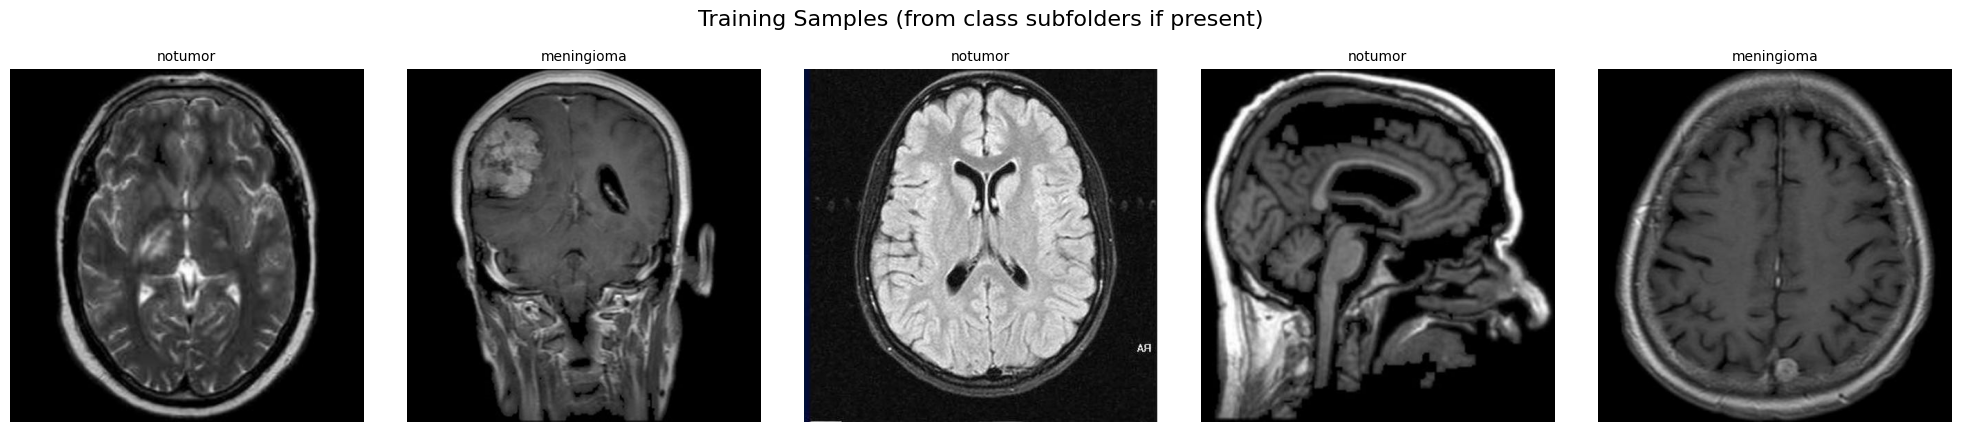

In [17]:
show_random_images("data/PMRAM_Dataset", "Training Samples (from class subfolders if present)")

Scanning subdirectories in data/Brain Tumor data as classes: ['pituitary', 'notumor', 'glioma', 'meningioma']


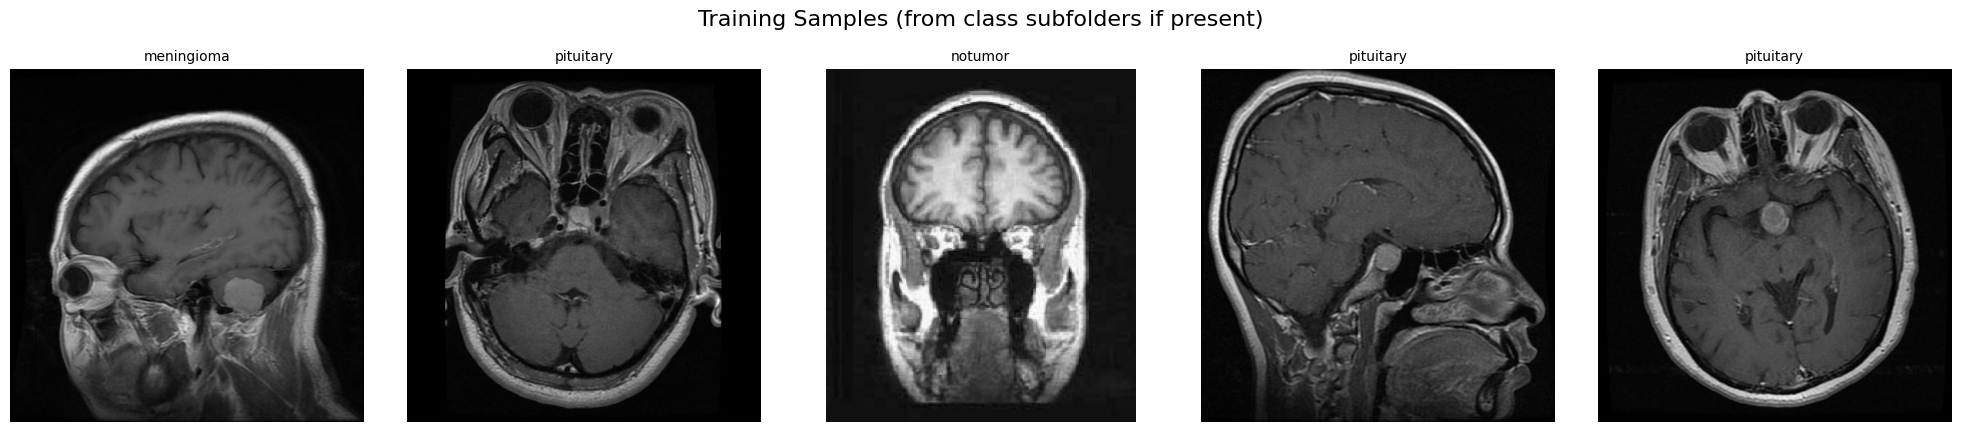

In [18]:
show_random_images("data/Brain Tumor data", "Training Samples (from class subfolders if present)")


Scanning subdirectories in data/China_Dataset as classes: ['pituitary', 'notumor', 'glioma', 'meningioma']


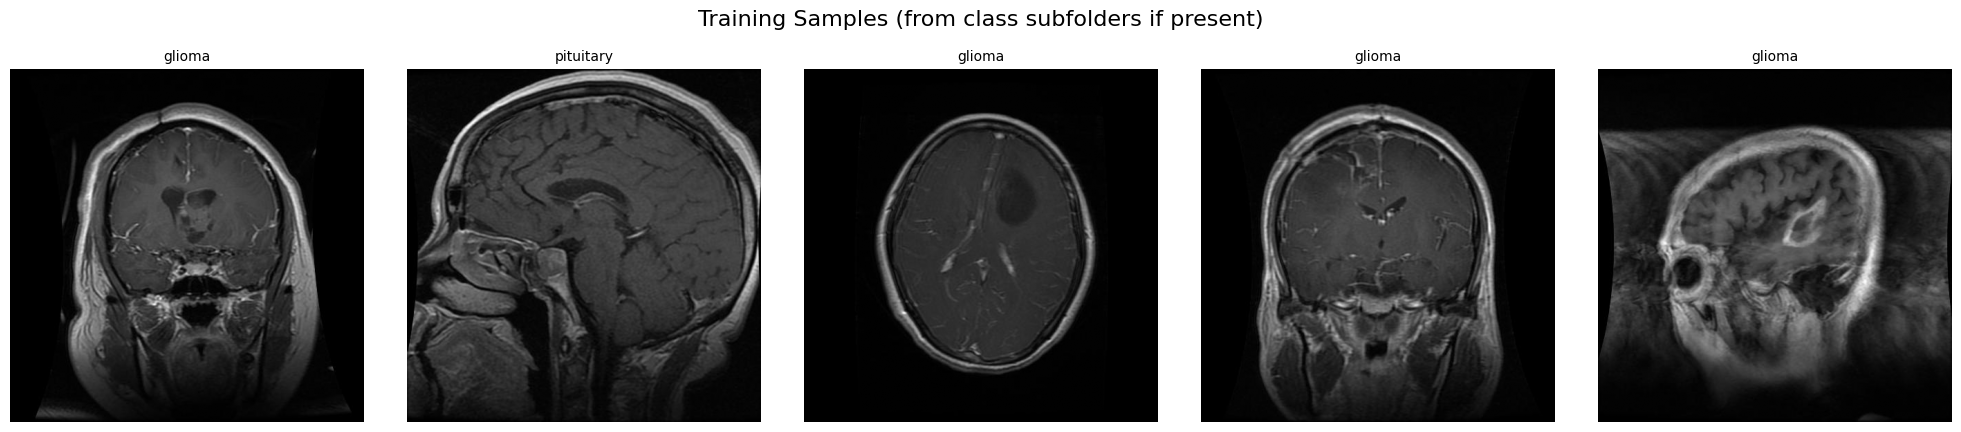

In [19]:
show_random_images("data/China_Dataset", "Training Samples (from class subfolders if present)")


Scanning subdirectories in data/AD VS CN Dataset as classes: ['notumor']


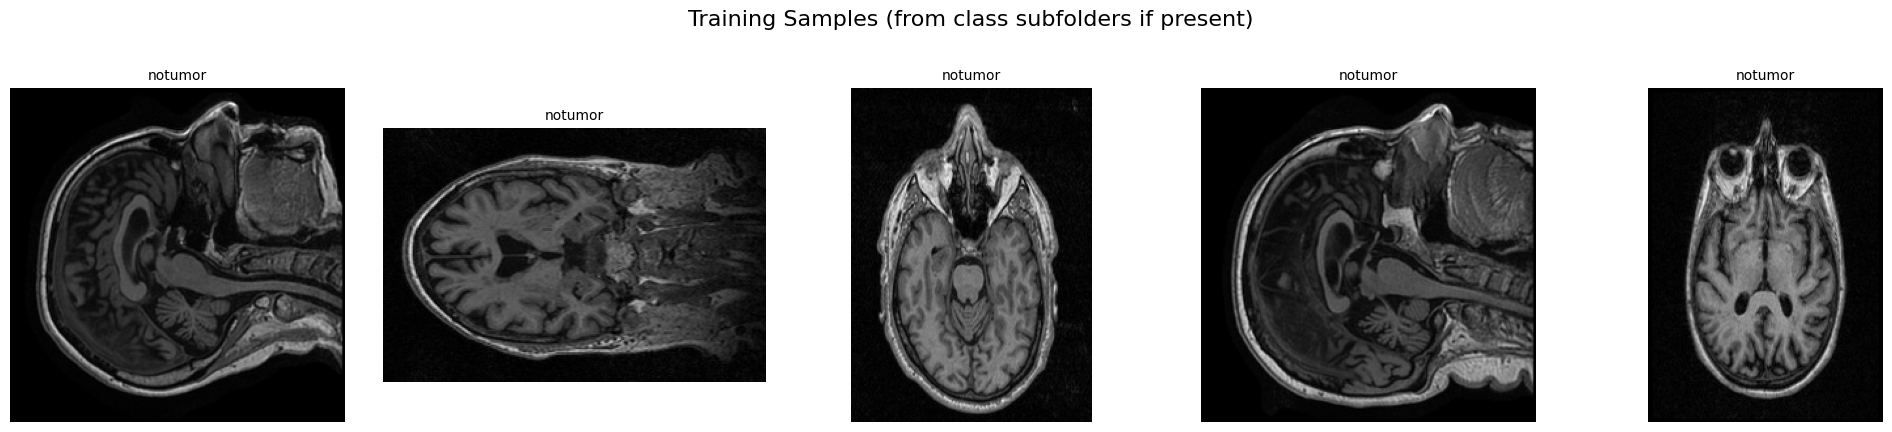

In [20]:
show_random_images("data/AD VS CN Dataset", "Training Samples (from class subfolders if present)")

Viewing image resolutions per dataset

 AD VS CN DATASET


,source,shape,count
25,AD VS CN Dataset,256×256,375
7,AD VS CN Dataset,166×256,191
19,AD VS CN Dataset,256×166,191
11,AD VS CN Dataset,192×160,180
2,AD VS CN Dataset,160×192,178


 BRAIN TUMOR


,source,shape,count
305,Brain Tumor,512×512,4496
91,Brain Tumor,225×225,91
330,Brain Tumor,630×630,31
156,Brain Tumor,256×256,30
117,Brain Tumor,236×236,23


 CHINA


,source,shape,count
360,China,512×512,1337
359,China,256×256,2


 PMRAM


,source,shape,count
361,PMRAM,512×512,726


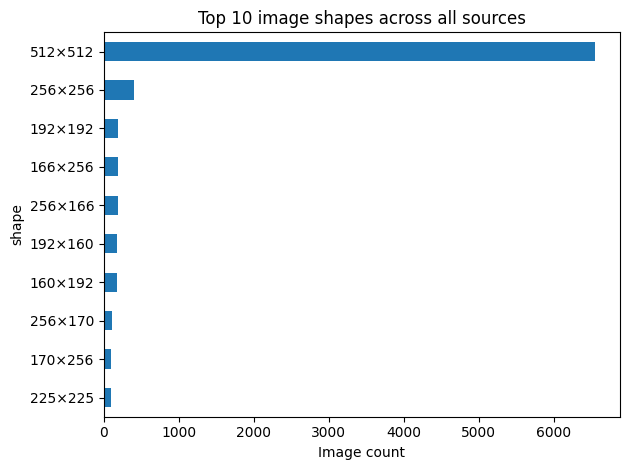

In [21]:
roots = {
    'Brain Tumor': Path('data/Brain Tumor data'),
    'China': Path('data/China_Dataset'),
    'PMRAM': Path('data/PMRAM_Dataset'),
    'AD VS CN Dataset': Path('data/AD VS CN Dataset')}

records = []
for src, root in roots.items(): # Creating a df with the source dataset, path, height and width of each image
    for fp in root.rglob('*.*'):
        if fp.suffix.lower() not in {'.jpg'}:
            continue
        img = cv2.imread(str(fp), cv2.IMREAD_UNCHANGED)
        if img is None:
            continue
        h, w = img.shape[:2]
        records.append(dict(source=src, path=str(fp), h=h, w=w))
df = pd.DataFrame(records)

df['shape'] = df[['h', 'w']].apply(lambda r: f"{r.h}×{r.w}", axis=1) # Transforming height and width into "height x width" ~ resolution

shape_counts = ( # Counting the number of images per source and resolution
    df.groupby(['source', 'shape'])
      .size()
      .reset_index(name='count')
      .sort_values(['source', 'count'], ascending=[True, False]))

for src in shape_counts['source'].unique():
    print(f" {src.upper()}")
    display(shape_counts.query('source == @src').head())

top_shapes = ( # Plotting the top 10 image shapes from all datasets
    df['shape']
      .value_counts()
      .head(10)
      .sort_values(ascending=True))

plt.figure()
top_shapes.plot(kind='barh')
plt.title('Top 10 image shapes across all sources')
plt.xlabel('Image count')
plt.tight_layout()
plt.show()

*Aspect ratio = image_height / image_width*

In [22]:
def calculate_aspect_ratio(image_path):
    """
    Calculates the aspect ratio: img_height/img_width
    """
    try:
        with Image.open(image_path) as img:
            width, height = img.size
            return height / width
    except Exception as e:
        print(f"Error calculating aspect ratio for {image_path}: {e}")
        return None

def calculate_size(image_path):
    """
    Calculates the size: img_width * img_height
    """
    try:
        with Image.open(image_path) as img:
            width, height = img.size
            return width * height
    except Exception as e:
        print(f"Error calculating size for {image_path}: {e}")
        return None

def load_image_metadata(base_dir):
    """
    Loads image metadata (aspect ratio and size) for all images in the dataset.
    """
    metadata = []
    for root, _, files in os.walk(base_dir):
        for file in files:
            if file.lower().endswith(('.jpg')):
                image_path = os.path.join(root, file)
                aspect_ratio = calculate_aspect_ratio(image_path)
                size = calculate_size(image_path)
                metadata.append({
                    "image_path": image_path,
                    "aspect_ratio": aspect_ratio,
                    "size": size})
    return pd.DataFrame(metadata)

In [23]:
# Define the base directory for the dataset
base_dir1 = "data/Brain Tumor data"
base_dir2 = "data/China_Dataset"
base_dir3 = "data/PMRAM_Dataset"
base_dir4 = "data/AD VS CN Dataset"

# Load image metadata
image_metadata1 = load_image_metadata(base_dir1)
image_metadata2 = load_image_metadata(base_dir2)
image_metadata3 = load_image_metadata(base_dir3)
image_metadata4 = load_image_metadata(base_dir4)
# Combine metadata from all datasets
image_metadata = pd.concat([image_metadata1, image_metadata2, image_metadata3, image_metadata4], ignore_index=True)

# Display the first few rows of the DataFrame
image_metadata.head()

,image_path,aspect_ratio,size
0,data/Brain Tumor data/pituitary/Tr-pi_0776.jpg,1.0,262144
1,data/Brain Tumor data/pituitary/Tr-pi_0452.jpg,1.0,262144
2,data/Brain Tumor data/pituitary/Tr-pi_0057.jpg,1.0,262144
3,data/Brain Tumor data/pituitary/Tr-pi_0156.jpg,1.0,262144
4,data/Brain Tumor data/pituitary/Tr-pi_0131.jpg,1.0,262144


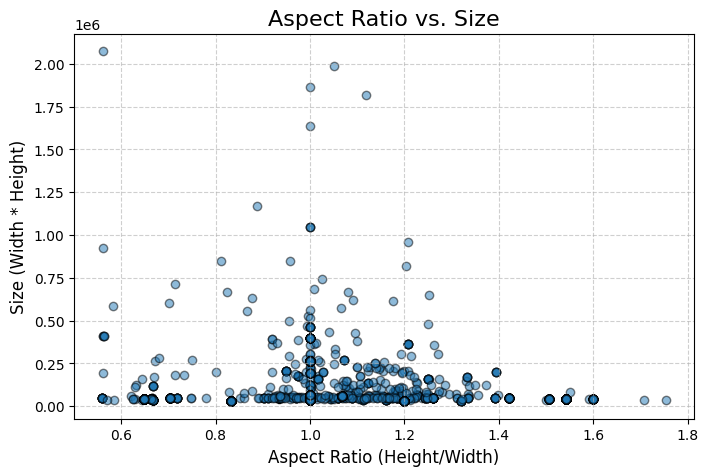

In [24]:
# Plotting all metadata
def plot_aspect_ratio_vs_size(metadata_df):
    """
    Create a scatterplot to visualize the relationship between aspect ratio and size.
    """
    plt.figure(figsize=(8, 5))
    plt.scatter(metadata_df["aspect_ratio"], metadata_df["size"], alpha=0.5, edgecolor="k")
    plt.title("Aspect Ratio vs. Size", fontsize=16)
    plt.xlabel("Aspect Ratio (Height/Width)", fontsize=12)
    plt.ylabel("Size (Width * Height)", fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()

# Plot the scatterplot
plot_aspect_ratio_vs_size(image_metadata)

Resizing all images to 256 x 256

In [25]:
def resize_images_in_folder(folder_path, target_size=(256, 256)):
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.lower().endswith(('.jpg')):
                file_path = os.path.join(root, file)
                img = cv2.imread(file_path)
                if img is not None:
                    resized_img = cv2.resize(img, target_size)
                    cv2.imwrite(file_path, resized_img)  # Overwriting original image

resize_images_in_folder("data/Brain Tumor data")
resize_images_in_folder("data/China_Dataset")
resize_images_in_folder("data/PMRAM_Dataset")
resize_images_in_folder("data/AD VS CN Dataset")

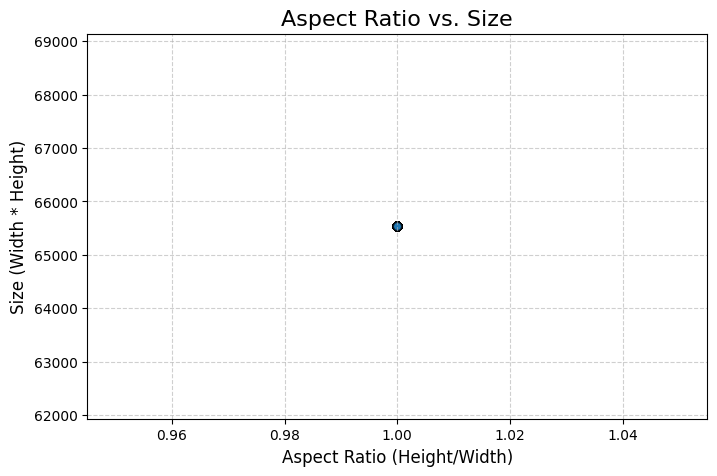

In [26]:
# Define the base directory for the dataset
base_dir1 = "data/Brain Tumor data"
base_dir2 = "data/China_Dataset"
base_dir3 = "data/PMRAM_Dataset"
base_dir4 = "data/AD VS CN Dataset"

# Load image metadata
image_metadata1 = load_image_metadata(base_dir1)
image_metadata2 = load_image_metadata(base_dir2)
image_metadata3 = load_image_metadata(base_dir3)
image_metadata4 = load_image_metadata(base_dir4)
# Combine the metadata DataFrames
image_metadata = pd.concat([image_metadata1, image_metadata2, image_metadata3, image_metadata4], ignore_index=True)

plot_aspect_ratio_vs_size(image_metadata)

Grayscaling

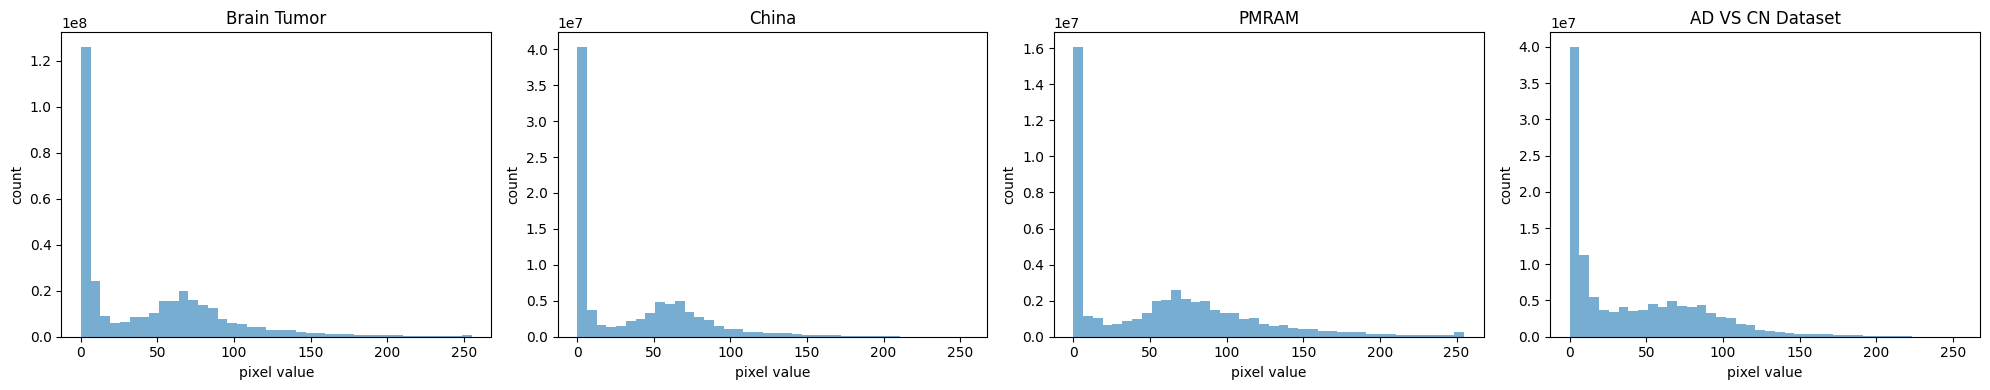

 RGB files that were converted: 56


In [27]:
rgb_mismatch = []          # files that are not flat grayscale
stats = defaultdict(list)

def load_single_channel(fp):
    """Read an image, collapse to 1-channel, collect diagnostics."""
    img = cv2.imread(str(fp), cv2.IMREAD_UNCHANGED)
    if img is None:
        raise ValueError(f"Cannot read {fp}")


    if img.ndim == 3: # Checking if it is an RGB image
        if np.allclose(img[:,:,0], img[:,:,1]) and np.allclose(img[:,:,0], img[:,:,2]): # If all 3 channels are similar, keep only 1
            img = img[:,:,0]
        else:
            rgb_mismatch.append(fp)   # If not, they're not grayscale, so we convert them.
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img



for _, row in df.iterrows():    # we created the df when we computed the size to aspect ratio
    img = load_single_channel(row.path)
    src = row.source
    stats[src].append(img)



fig, axes = plt.subplots(1, len(stats), figsize=(5*len(stats), 4)) # Plotting histograms of pixel values
if len(stats) == 1:
    axes = [axes]

for ax, (src, imgs) in zip(axes, stats.items()):
    ax.hist(np.concatenate([im.ravel() for im in imgs]),
            bins=40, alpha=.6)
    ax.set_title(src)
    ax.set_xlabel("pixel value")
    ax.set_ylabel("count")
plt.tight_layout(); plt.show()


if rgb_mismatch: # Printing number of images that were not grayscale
    print(f" RGB files that were converted: {len(rgb_mismatch)}")


**Merging & Splitting Datasets**

Merging datasets into one dataset before split.

In [28]:
# Source and target, used for running multiple times
if os.path.exists('merged_dataset'):
    shutil.rmtree('merged_dataset')

In [29]:
input_base = 'data'
output_base = 'merged_dataset'
os.makedirs(output_base, exist_ok=True)

image_counts = defaultdict(int)

for dataset in os.listdir(input_base): # Merging process
    dataset_path = os.path.join(input_base, dataset)
    if not os.path.isdir(dataset_path):
        continue

    for root, dirs, files in os.walk(dataset_path):
        label_folder = os.path.basename(root)

        if label_folder in ['glioma', 'meningioma', 'pituitary', 'notumor']: # Only processing class folders
            target_dir = os.path.join(output_base, label_folder)
            os.makedirs(target_dir, exist_ok=True)

            for f in files:
                if f.lower().endswith(('.jpg')):
                    src = os.path.join(root, f)
                    dst = os.path.join(target_dir, f"{dataset}_{label_folder}_{f}")
                    shutil.copy2(src, dst)
                    image_counts[label_folder] += 1

print("Merge complete. Image count by class:")
for label, count in image_counts.items():
    print(f"  {label}: {count} images")

Merge complete. Image count by class:
  pituitary: 1785 images
  glioma: 2891 images
  meningioma: 1788 images
  notumor: 2671 images


Splitting: Train - Test - Validation

In [30]:
if os.path.exists('split_dataset'):
    shutil.rmtree('split_dataset')

os.makedirs('split_dataset', exist_ok=True)

# Paths
merged_dir = 'merged_dataset'
output_dir = 'split_dataset'

random.seed(42)

# Split ratio
ratios = (0.70, 0.15, 0.15) # train 70%, val 15%, test 15%

train_dir = os.path.join(output_dir, 'train')
validation_dir = os.path.join(output_dir, 'validation')
test_dir = os.path.join(output_dir, 'test')

# Creating output directories
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)
for dir in (train_dir, validation_dir, test_dir):
    os.makedirs(dir, exist_ok=True)


for class_name in os.listdir(merged_dir):
    class_path = os.path.join(merged_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    # making class sub-folders
    for root in (train_dir, validation_dir, test_dir):
        os.makedirs(os.path.join(root, class_name), exist_ok=True)

    # Getting all images their respective folder and shuffling
    images = os.listdir(class_path)
    random.shuffle(images)

    # Split images into Train - Test - Validation sets.
    n       = len(images)
    n_train = int(n * ratios[0])
    n_val   = int(n * ratios[1])

    splits = {
        train_dir: images[:n_train],
        validation_dir  : images[n_train:n_train + n_val],
        test_dir : images[n_train + n_val:]}

    # move / copy
    for split_root, file_list in splits.items():
        for fname in file_list:
            src = os.path.join(class_path, fname)
            dst = os.path.join(split_root, class_name, fname)
            shutil.copy2(src, dst)

print('Dataset split 70-15-15 complete.')

Dataset split 70-15-15 complete.


 Distributions per Split and per Class

            train  validation  test
pituitary    1249         267   269
notumor      1869         400   402
glioma       2023         433   435
meningioma   1251         268   269


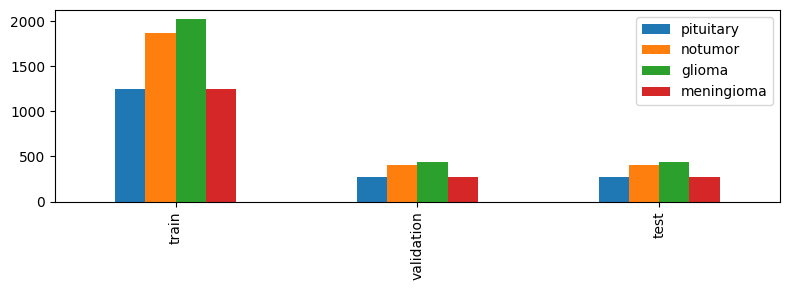

In [31]:
root='split_dataset'; splits=['train','validation','test']
counts=collections.defaultdict(lambda:collections.Counter())
for split in splits:
    for cls in os.listdir(os.path.join(root,split)):
        p=os.path.join(root,split,cls)
        counts[cls][split]=sum(f.lower().endswith(('.jpg')) for f in os.listdir(p))
df=pd.DataFrame(counts).T.fillna(0).astype(int)
print(df)   # table of images per class per split

# total images per split (dataset distribution)
df.T.plot.bar(figsize=(8,3)); plt.tight_layout(); plt.show()

Augmentation

*We are adding synthetic data through Augmentation for the Train set to be balanced*

In [32]:
def rotate_image(image): # Image rotation
    angle = random.uniform(-15, 15)  # Random angle between -15 - 15 degrees
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    mat = cv2.getRotationMatrix2D(center, angle, 1.0)
    return cv2.warpAffine(image, mat, (w, h), borderMode=cv2.BORDER_REFLECT)

def zoom_image(image): # Image zoom
    zoom_factor = random.uniform(0.8, 1.2)  # Random zooming by 0.8 - 1.2
    h, w = image.shape[:2]
    new_h, new_w = int(h * zoom_factor), int(w * zoom_factor)
    resized = cv2.resize(image, (new_w, new_h))
    if zoom_factor > 1:
        start_x = (new_w - w) // 2
        start_y = (new_h - h) // 2
        return resized[start_y:start_y + h, start_x:start_x + w]
    else:
        # Pad
        pad_x = (w - new_w) // 2
        pad_y = (h - new_h) // 2
        padded = cv2.copyMakeBorder(
            resized, pad_y, h - new_h - pad_y, pad_x, w - new_w - pad_x,
            borderType=cv2.BORDER_REFLECT
        )
        return padded

def apply_light_blur(image):
    kernel_size = random.choice([3, 5, 7])  # Random kernel size (odd numbers)
    sigma = random.uniform(0.1, 1.0)  # Random sigma value
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), sigma)

def apply_random_brightness(image, max_delta=0.2): #max +20%
    orig_dtype = image.dtype
    image = image.astype(np.float32)

    delta = random.uniform(-max_delta, max_delta)
    image = image * (1.0 + delta)
    image = np.clip(image, 0, 255)

    return image.astype(orig_dtype)


In [33]:
train_dir = 'split_dataset/train'
target_count = 2023 # biggest number out of all the classes in train set
random.seed(42) # Using specific seed to ensure reproducibility

augmentation_funcs = {
    'rotate': rotate_image,
    'zoom': zoom_image,
    'blur': apply_light_blur,
    'brightness': apply_random_brightness}

for class_name in sorted(os.listdir(train_dir)): # Augmenting each class
    class_path = os.path.join(train_dir, class_name)
    if not os.path.isdir(class_path):
        continue
    images = sorted(glob(os.path.join(class_path, '*')))
    original_count = len(images)
    if original_count >= target_count:
        continue
    print(f"Augmenting {class_name}: {original_count} -> {target_count}")

    needed = target_count - original_count
    aug_index = 0

    while needed > 0:
        image_path = images[aug_index % original_count]
        img = cv2.imread(image_path)
        if img is None:
            aug_index += 1
            continue

        aug_type = random.choice(list(augmentation_funcs.keys())) # Randomnly select augmentation method
        aug_func = augmentation_funcs[aug_type]

        aug_img = aug_func(img)
        aug_img = cv2.resize(aug_img, (256, 256))

        base_name = os.path.splitext(os.path.basename(image_path))[0]
        aug_name = f"{base_name}_aug{aug_index}_{aug_type}.jpg"
        aug_path = os.path.join(class_path, aug_name)

        cv2.imwrite(aug_path, aug_img)

        needed -= 1
        aug_index += 1

print("Augmentation complete")

Augmenting meningioma: 1251 -> 2023
Augmenting notumor: 1869 -> 2023
Augmenting pituitary: 1249 -> 2023
Augmentation complete


            train  validation  test
pituitary    2023         267   269
notumor      2023         400   402
glioma       2023         433   435
meningioma   2023         268   269


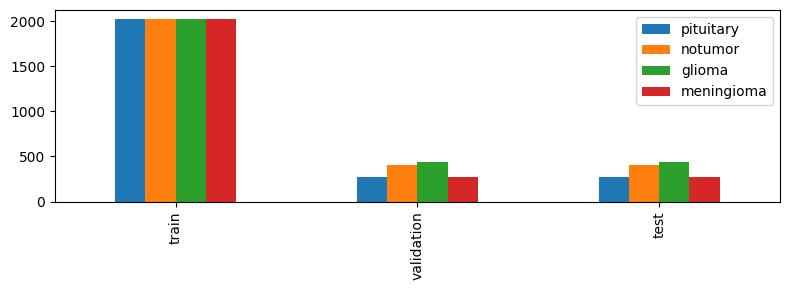

In [34]:
#checking again for data unbalances
root='split_dataset'; splits=['train','validation','test']
counts=collections.defaultdict(lambda:collections.Counter())
for split in splits:
    for cls in os.listdir(os.path.join(root,split)):
        p=os.path.join(root,split,cls)
        counts[cls][split]=sum(f.lower().endswith(('.jpg')) for f in os.listdir(p))
df2=pd.DataFrame(counts).T.fillna(0).astype(int)
print(df2)  # table of images per class per split

# total images per split (dataset‑level distribution)
df2.T.plot.bar(figsize=(8,3)); plt.tight_layout(); plt.show()

Part III

**MODELS**

In [64]:
# Paths to the dataset
train_dir = 'split_dataset/train'
test_dir = 'split_dataset/test'
validation_dir = 'split_dataset/validation'

# Image dimensions and batch size
img_height, img_width = 256, 256
batch_size = 32
n_classes = 4  # glioma, meningioma, pituitary, notumor

# Data generators for loading and preprocessing grayscale images
train_image_generator = ImageDataGenerator(rescale=1.0 / 255.0)
validation_image_generator = ImageDataGenerator(rescale=1.0 / 255.0)
test_image_generator = ImageDataGenerator(rescale=1.0 / 255.0)


train_data_gen = train_image_generator.flow_from_directory(batch_size= batch_size,
                                                              directory= train_dir ,
                                                              target_size= (img_height, img_width), # We use it for optimization
                                                              color_mode='grayscale', # same as above
                                                              class_mode='sparse' )

val_data_gen = validation_image_generator.flow_from_directory(batch_size= batch_size,
                                                              directory= validation_dir,
                                                              target_size= (img_height, img_width),
                                                              color_mode='grayscale',
                                                              class_mode='sparse' )

test_data_gen = test_image_generator.flow_from_directory(batch_size= batch_size,
                                                              directory= test_dir,
                                                              target_size= (img_height, img_width),
                                                              color_mode='grayscale',
                                                              class_mode='sparse' )

class_names = list(test_data_gen.class_indices.keys()) #get class names from the generator

train_steps = len(train_data_gen)
val_steps = len(val_data_gen)
test_steps = len(test_data_gen)

# Loss function & metrics
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
train_loss = tf.keras.metrics.Mean(name="loss")
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy")
val_loss = tf.keras.metrics.Mean(name="val_loss")
val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name="val_accuracy")

Found 8092 images belonging to 4 classes.
Found 1368 images belonging to 4 classes.
Found 1375 images belonging to 4 classes.


Model 1

In [36]:
model0 = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(img_height, img_width, 1)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(n_classes, activation='softmax')])

# Training parameters
n_epochs = 15

train_loss_history = []
val_loss_history = []

# Defining 2 optimizers
first_opt = tf.keras.optimizers.SGD(learning_rate=1e-4)
second_opt = tf.keras.optimizers.Nadam(learning_rate=1e-3)


# Custom training loop
for epoch in range(1, n_epochs + 1):
    print(f"Epoch {epoch}/{n_epochs}")

    # Training loop
    for step in range(train_steps):
        X_batch, y_batch = next(train_data_gen)
        with tf.GradientTape(persistent=True) as tape:
            y_pred = model0(X_batch, training=True)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            loss = tf.add_n([main_loss] + model0.losses)

        train_accuracy.update_state(y_batch, y_pred)
        gradients = tape.gradient(loss, model0.trainable_variables)

        first_opt.apply_gradients(zip(gradients[:2], model0.layers[1].trainable_variables))  # Lower layer
        second_opt.apply_gradients(zip(gradients[2:], model0.layers[2].trainable_variables))  # Upper layer
        train_loss(loss)

    # Validation loop
    for step in range(val_steps):  # Added validation loop
        X_batch, y_batch = next(val_data_gen)  # Use validation generator
        y_val_pred = model0(X_batch, training=False)
        val_loss.update_state(loss_fn(y_batch, y_val_pred))
        val_accuracy.update_state(y_batch, y_val_pred)

    # Store the loss values for this epoch
    train_loss_history.append(train_loss.result().numpy())
    val_loss_history.append(val_loss.result().numpy())

    # Print metrics
    print(f"Train Loss: {train_loss.result():.4f}, Train Accuracy: {train_accuracy.result():.4f}, "
          f"Val Loss: {val_loss.result():.4f}, Val Accuracy: {val_accuracy.result():.4f}")

    # Reset metrics
    for metric in [train_loss, train_accuracy, val_loss, val_accuracy]:
        metric.reset_state()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
Train Loss: 1.2282, Train Accuracy: 0.4838, Val Loss: 1.0706, Val Accuracy: 0.5892
Epoch 2/15
Train Loss: 0.9942, Train Accuracy: 0.6152, Val Loss: 0.9021, Val Accuracy: 0.6615
Epoch 3/15
Train Loss: 0.8878, Train Accuracy: 0.6511, Val Loss: 0.8498, Val Accuracy: 0.6615
Epoch 4/15
Train Loss: 0.8235, Train Accuracy: 0.6775, Val Loss: 0.7853, Val Accuracy: 0.7047
Epoch 5/15
Train Loss: 0.7788, Train Accuracy: 0.6940, Val Loss: 0.7543, Val Accuracy: 0.7083
Epoch 6/15
Train Loss: 0.7427, Train Accuracy: 0.7086, Val Loss: 0.7357, Val Accuracy: 0.7120
Epoch 7/15
Train Loss: 0.7116, Train Accuracy: 0.7216, Val Loss: 0.7225, Val Accuracy: 0.7032
Epoch 8/15
Train Loss: 0.6870, Train Accuracy: 0.7360, Val Loss: 0.6843, Val Accuracy: 0.7368
Epoch 9/15
Train Loss: 0.6615, Train Accuracy: 0.7477, Val Loss: 0.6780, Val Accuracy: 0.7376
Epoch 10/15
Train Loss: 0.6387, Train Accuracy: 0.7584, Val Loss: 0.6538, Val Accuracy: 0.7493
Epoch 11/15
Train Loss: 0.6176, Train Accuracy: 0.7699, Val

In [37]:
#Create a function to show additional metrics in  a nice format

def evaluate_model_on_test(model, test_data_gen, test_steps, class_names):
    """
    Evaluate a trained model on the test set and compute metrics.

    Parameters:
    - model: Trained model to evaluate.
    - test_data_gen: Test data generator.
    - test_steps: Number of steps in the test generator.
    - class_names: List of class names for the classification report.

    Returns:
    - None, only prints metrics
    """
    y_true = []  # True labels
    y_pred = []  # Predicted labels
    y_prob = []  # Predicted probabilities

    # Iterate through the test data generator
    for _ in range(test_steps):
        X_batch, y_batch = next(test_data_gen)
        y_true.extend(y_batch)  # Append true labels
        y_prob_batch = model.predict(X_batch, verbose=0)  # Predict probabilities
        y_pred_batch = np.argmax(y_prob_batch, axis=1)  # Convert probabilities to class labels
        y_pred.extend(y_pred_batch)
        y_prob.extend(y_prob_batch)

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_prob = np.array(y_prob)

    # Compute classification metrics
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Compute F1-score
    f1_macro = f1_score(y_true, y_pred, average='macro')
    print(f"Macro F1-Score: {f1_macro:.2f}")

    # Compute ROC-AUC
    roc_auc_macro = roc_auc_score(y_true, y_prob, multi_class='ovr', average='macro')
    print(f"Macro ROC-AUC: {roc_auc_macro:.2f}")

    # Compute accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {accuracy:.2f}")

In [38]:
def display_predictions(model, data_gen, class_names, num_images):
    """
    Display a few images with their true labels, predicted labels, and probabilities.

    Parameters:
    - model: Trained CNN model.
    - data_gen: Data generator (e.g., test_data_gen).
    - class_names: List of class names.
    - num_images: Number of images to display.
    """
    X_batch, y_true = next(data_gen)  # Get a batch of images and labels
    y_prob = model.predict(X_batch)  # Predict probabilities
    y_pred = np.argmax(y_prob, axis=1)  # Get predicted labels

    plt.figure(figsize=(8, 4))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(X_batch[i].squeeze(), cmap='gray')  # Display grayscale image
        true_label = class_names[int(y_true[i])]
        pred_label = class_names[int(y_pred[i])]
        prob = np.max(y_prob[i])  # Get the highest probability
        plt.title(f"True: {true_label}\nPred: {pred_label}\nProb: {prob:.2f}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()


In [39]:
evaluate_model_on_test(model0, test_data_gen, test_steps, class_names)

Classification Report:
              precision    recall  f1-score   support

      glioma       0.76      0.71      0.73       435
  meningioma       0.49      0.52      0.51       269
     notumor       0.85      0.87      0.86       402
   pituitary       0.82      0.84      0.83       269

    accuracy                           0.74      1375
   macro avg       0.73      0.73      0.73      1375
weighted avg       0.74      0.74      0.74      1375

Macro F1-Score: 0.73
Macro ROC-AUC: 0.91
Accuracy: 0.74


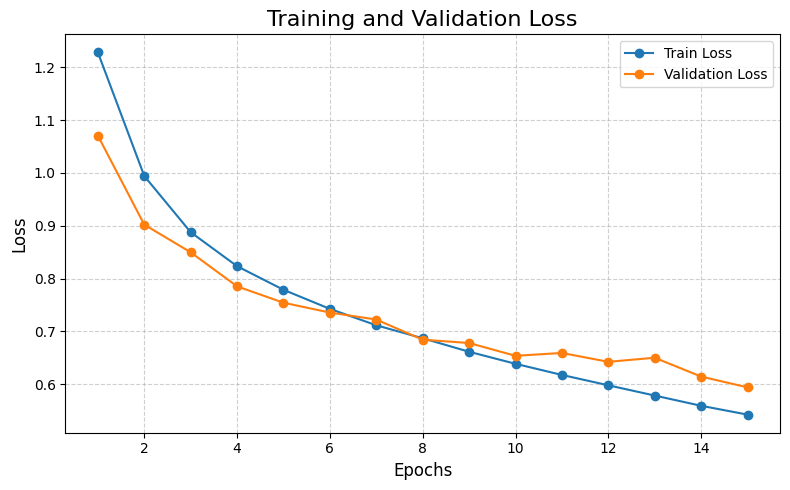

In [40]:
plt.figure(figsize=(8, 5))
epochs = range(1, n_epochs + 1)
plt.plot(epochs, train_loss_history, label="Train Loss", marker='o')
plt.plot(epochs, val_loss_history, label="Validation Loss", marker='o')
plt.title("Training and Validation Loss", fontsize=16)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

Model 2

In [41]:
model1 = tf.keras.models.Sequential ([
    Conv2D (16, 3, padding='same', activation='relu', input_shape=(img_height, img_width, 1)),
    BatchNormalization(), #normalize the feature maps
    MaxPooling2D(), #default 2x2
    Dropout(0.15),
    Conv2D (32, 3, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(0.15),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(n_classes, activation='softmax')])

n_epochs = 15


train_loss_history = []
val_loss_history = []

# Define a single optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

# Custom training loop
for epoch in range(1, n_epochs + 1):
    print(f"Epoch {epoch}/{n_epochs}")

    # Training loop
    for step in range(train_steps):
        X_batch, y_batch = next(train_data_gen)
        with tf.GradientTape() as tape:
            y_pred = model1(X_batch, training=True)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            loss = tf.add_n([main_loss] + model1.losses)

        gradients = tape.gradient(loss, model1.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model1.trainable_variables))

        train_loss.update_state(loss)
        train_accuracy.update_state(y_batch, y_pred)

    # Validation loop
    for step in range(val_steps):
        X_batch, y_batch = next(val_data_gen)
        y_val_pred = model1(X_batch, training=False)
        val_loss.update_state(loss_fn(y_batch, y_val_pred))
        val_accuracy.update_state(y_batch, y_val_pred)

    # Store the loss values for this epoch
    train_loss_history.append(train_loss.result().numpy())
    val_loss_history.append(val_loss.result().numpy())

    # Print metrics
    print(f"Train Loss: {train_loss.result():.4f}, Train Accuracy: {train_accuracy.result():.4f}, "
          f"Val Loss: {val_loss.result():.4f}, Val Accuracy: {val_accuracy.result():.4f}")

    # Reset metrics
    train_loss.reset_state()
    train_accuracy.reset_state()
    val_loss.reset_state()
    val_accuracy.reset_state()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
Train Loss: 3.1123, Train Accuracy: 0.7011, Val Loss: 84.7876, Val Accuracy: 0.3202
Epoch 2/15
Train Loss: 0.6769, Train Accuracy: 0.8448, Val Loss: 50.8311, Val Accuracy: 0.3845
Epoch 3/15
Train Loss: 0.3279, Train Accuracy: 0.9022, Val Loss: 1.8305, Val Accuracy: 0.7895
Epoch 4/15
Train Loss: 0.1869, Train Accuracy: 0.9376, Val Loss: 1.1591, Val Accuracy: 0.8224
Epoch 5/15
Train Loss: 0.1469, Train Accuracy: 0.9493, Val Loss: 0.6159, Val Accuracy: 0.8545
Epoch 6/15
Train Loss: 0.1137, Train Accuracy: 0.9601, Val Loss: 0.7556, Val Accuracy: 0.8494
Epoch 7/15
Train Loss: 0.0900, Train Accuracy: 0.9705, Val Loss: 0.7622, Val Accuracy: 0.8509
Epoch 8/15
Train Loss: 0.0790, Train Accuracy: 0.9724, Val Loss: 0.9911, Val Accuracy: 0.8041
Epoch 9/15
Train Loss: 0.0844, Train Accuracy: 0.9722, Val Loss: 1.3959, Val Accuracy: 0.8165
Epoch 10/15
Train Loss: 0.0573, Train Accuracy: 0.9799, Val Loss: 1.1813, Val Accuracy: 0.8070
Epoch 11/15
Train Loss: 0.1010, Train Accuracy: 0.9684, V

In [42]:
evaluate_model_on_test(model1, test_data_gen, test_steps, class_names)

Classification Report:
              precision    recall  f1-score   support

      glioma       0.91      0.82      0.86       435
  meningioma       0.68      0.88      0.76       269
     notumor       0.99      0.88      0.93       402
   pituitary       0.91      0.96      0.93       269

    accuracy                           0.87      1375
   macro avg       0.87      0.88      0.87      1375
weighted avg       0.89      0.87      0.88      1375

Macro F1-Score: 0.87
Macro ROC-AUC: 0.97
Accuracy: 0.87


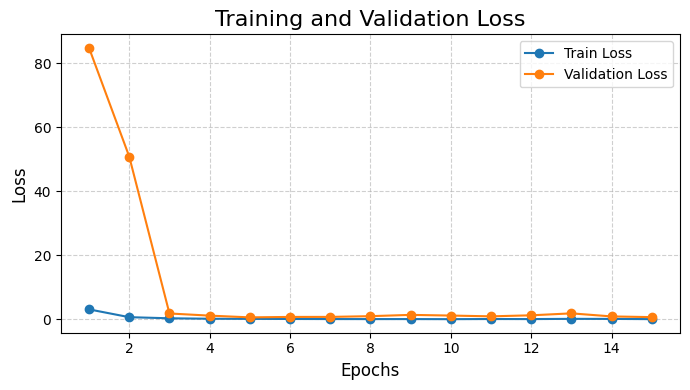

In [43]:
# Plot the training and validation loss
plt.figure(figsize=(7, 4))
epochs = range(1, n_epochs + 1)
plt.plot(epochs, train_loss_history, label="Train Loss", marker='o')
plt.plot(epochs, val_loss_history, label="Validation Loss", marker='o')
plt.title("Training and Validation Loss", fontsize=16)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

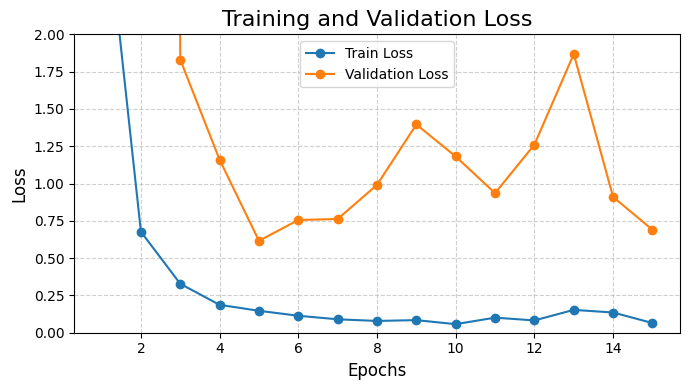

In [44]:
# Plot the training and validation loss
plt.figure(figsize=(7, 4))
epochs = range(1, n_epochs + 1)
plt.plot(epochs, train_loss_history, label="Train Loss", marker='o')
plt.plot(epochs, val_loss_history, label="Validation Loss", marker='o')
plt.title("Training and Validation Loss", fontsize=16)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.ylim(0, 2)  # Set Y-axis limits to zoom into the more relevant loss range
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


In [70]:
# This is a variation of the previous model, with slight differences but similar structure.
model2 = models.Sequential()
model2.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 1)))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Dropout(0.2))
model2.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.005)))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.005)))
model2.add(layers.Dropout(0.2))
model2.add(layers.Flatten())
model2.add(layers.Dense(128, activation='relu'))
model2.add(layers.Dropout(0.3))
model2.add(layers.Dense(n_classes, activation='softmax'))

# Training parameters
n_epochs = 7

train_loss_history = []
val_loss_history = []

# Define a single optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

# Custom training loop
for epoch in range(1, n_epochs + 1):
    print(f"Epoch {epoch}/{n_epochs}")

    # Training loop
    for step in range(train_steps):
        X_batch, y_batch = next(train_data_gen)
        with tf.GradientTape() as tape:
            y_pred = model2(X_batch, training=True)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            loss = tf.add_n([main_loss] + model2.losses)

        gradients = tape.gradient(loss, model2.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model2.trainable_variables))

        train_loss.update_state(loss)
        train_accuracy.update_state(y_batch, y_pred)

    # Validation loop
    for step in range(val_steps):
        X_batch, y_batch = next(val_data_gen)
        y_val_pred = model2(X_batch, training=False)
        val_loss.update_state(loss_fn(y_batch, y_val_pred))
        val_accuracy.update_state(y_batch, y_val_pred)

    # Store the loss values for this epoch
    train_loss_history.append(train_loss.result().numpy())
    val_loss_history.append(val_loss.result().numpy())

    # Print metrics
    print(f"Train Loss: {train_loss.result():.4f}, Train Accuracy: {train_accuracy.result():.4f}, "
          f"Val Loss: {val_loss.result():.4f}, Val Accuracy: {val_accuracy.result():.4f}")

    # Reset metrics
    train_loss.reset_state()
    train_accuracy.reset_state()
    val_loss.reset_state()
    val_accuracy.reset_state()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/7
Train Loss: 0.9815, Train Accuracy: 0.7091, Val Loss: 0.4841, Val Accuracy: 0.7858
Epoch 2/7
Train Loss: 0.5189, Train Accuracy: 0.8481, Val Loss: 0.3522, Val Accuracy: 0.8589
Epoch 3/7
Train Loss: 0.3600, Train Accuracy: 0.8952, Val Loss: 0.2836, Val Accuracy: 0.8925
Epoch 4/7
Train Loss: 0.2501, Train Accuracy: 0.9345, Val Loss: 0.3169, Val Accuracy: 0.8743
Epoch 5/7
Train Loss: 0.1935, Train Accuracy: 0.9514, Val Loss: 0.2856, Val Accuracy: 0.9035
Epoch 6/7
Train Loss: 0.1482, Train Accuracy: 0.9653, Val Loss: 0.3263, Val Accuracy: 0.8984
Epoch 7/7
Train Loss: 0.1357, Train Accuracy: 0.9676, Val Loss: 0.2869, Val Accuracy: 0.9115


In [46]:
evaluate_model_on_test(model2, test_data_gen, test_steps, class_names)

Classification Report:
              precision    recall  f1-score   support

      glioma       0.94      0.83      0.88       435
  meningioma       0.73      0.86      0.79       269
     notumor       0.97      0.94      0.96       402
   pituitary       0.93      0.99      0.96       269

    accuracy                           0.90      1375
   macro avg       0.89      0.90      0.90      1375
weighted avg       0.91      0.90      0.90      1375

Macro F1-Score: 0.90
Macro ROC-AUC: 0.98
Accuracy: 0.90


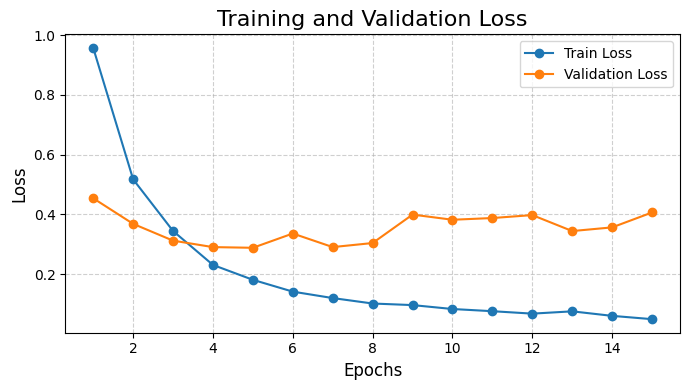

In [47]:
# Plot the training and validation loss
plt.figure(figsize=(7, 4))
epochs = range(1, n_epochs + 1)
plt.plot(epochs, train_loss_history, label="Train Loss", marker='o')
plt.plot(epochs, val_loss_history, label="Validation Loss", marker='o')
plt.title("Training and Validation Loss", fontsize=16)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


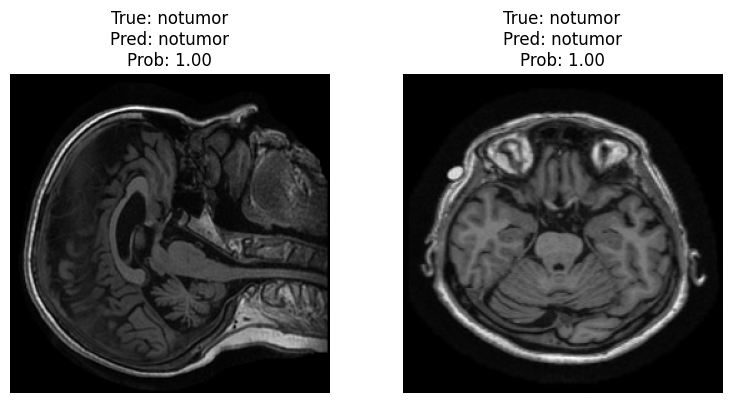

In [48]:
display_predictions(model2, test_data_gen, class_names, num_images=2)

In [69]:
#Used during testing to run the models multiple times on a clean environment
#without having to restart the kernel and re-run the entire code

from tensorflow.keras import backend as K
import gc

K.clear_session()
gc.collect()


0

In [50]:
#block. Use CPU
# In order to increase efficiency and reduce resources use we run the code using thwo different runtimes

Model 3

In [51]:
class HOGTransformer(BaseEstimator, TransformerMixin):
    def __init__(self,
                 orientations=9,
                 pixels_per_cell=(8, 8),
                 cells_per_block=(2, 2),
                 transform_sqrt=False):
        self.orientations      = orientations
        self.pixels_per_cell   = pixels_per_cell
        self.cells_per_block   = cells_per_block
        self.transform_sqrt    = transform_sqrt

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        params = dict(orientations     = self.orientations,
                      pixels_per_cell  = self.pixels_per_cell,
                      cells_per_block  = self.cells_per_block,
                      transform_sqrt   = self.transform_sqrt,
                      block_norm       ='L2-Hys')
        return np.array([hog(img.squeeze() if img.ndim == 3 else img, **params) for img in X])
        #return np.array([hog(img, **params) for img in X])


def load_split(root_dir):
    X, y, labels = [], [], sorted(os.listdir(root_dir))
    for idx, cls in enumerate(labels):
        cls_path = pathlib.Path(root_dir, cls)
        for fp in cls_path.iterdir():
            img = cv2.imread(str(fp), cv2.IMREAD_GRAYSCALE)

            if img is not None:
                img = cv2.resize(img, (128, 128))  # Resizing to 128×128
                X.append(img)
                y.append(idx)
    return np.array(X), np.array(y), labels

X_train, y_train, LABELS = load_split('split_dataset/train')
X_val,   y_val,   _      = load_split('split_dataset/validation')
X_test,  y_test,  _      = load_split('split_dataset/test')

In [52]:
# Non Optimized version
model3 = Pipeline([
        ('hog',   HOGTransformer(orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), transform_sqrt=True)),
        ('scale', StandardScaler()),
        ('pca', PCA(n_components=0.95,whiten=True,random_state=42)),
        ('svm',   SVC(kernel='rbf', C=10, gamma=0.01,
    probability=True,
    max_iter=400,  class_weight='balanced',verbose=True))])

model3.fit(X_train, y_train)

y_val_prob = model3.predict_proba(X_val) # Predict class probabilities
y_pred = model3.predict(X_val)

# Calculate training accuracy
y_train_pred = model3.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training accuracy: {train_accuracy:.2f}")

# Calculate ROC-AUC score (macro-average)
roc_auc = roc_auc_score(y_val, y_val_prob, multi_class='ovr', average='macro')

print("Validation accuracy:", accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred, target_names=LABELS))
print(f"Macro ROC-AUC: {roc_auc:.2f}")


[LibSVM]

/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=400).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Training accuracy: 0.74
Validation accuracy: 0.6301169590643275
              precision    recall  f1-score   support

      glioma       0.75      0.55      0.63       433
  meningioma       0.88      0.30      0.45       268
     notumor       0.49      0.99      0.66       400
   pituitary       0.94      0.55      0.70       267

    accuracy                           0.63      1368
   macro avg       0.77      0.60      0.61      1368
weighted avg       0.74      0.63      0.62      1368

Macro ROC-AUC: 0.92


In [53]:
# Optimizer running for n = 20 iterations on full dataset, max_iter=1000
# Given the high computational load, we ran it only once and decided to comment it out
# to reduce computational time and save resources
'''
class HOGTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, orientations=9, pixels_per_cell=8, cells_per_block=2, transform_sqrt=False):
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.transform_sqrt = transform_sqrt

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        ppc = (self.pixels_per_cell, self.pixels_per_cell) \
              if isinstance(self.pixels_per_cell, int) else self.pixels_per_cell
        cpb = (self.cells_per_block, self.cells_per_block) \
              if isinstance(self.cells_per_block, int) else self.cells_per_block
        params = dict(orientations=self.orientations, pixels_per_cell=ppc,
                      cells_per_block=cpb, transform_sqrt=self.transform_sqrt,
                      block_norm='L2-Hys')
        return np.array([hog(img, **params) for img in X])

def load_split(root_dir):
    X, y, labels = [], [], sorted(os.listdir(root_dir))
    for idx, cls in enumerate(labels):
        for fp in pathlib.Path(root_dir, cls).iterdir():
            img = cv2.imread(str(fp), cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            img = cv2.resize(img, (128, 128))
            X.append(img)
            y.append(idx)
    return np.array(X), np.array(y), labels

X_train, y_train, LABELS = load_split('split_dataset/train')
X_val,   y_val,   _      = load_split('split_dataset/validation')


base_pipe = Pipeline([
    ('hog',   HOGTransformer(transform_sqrt=True)),
    ('scale', StandardScaler()),
    ('pca',   PCA(n_components=0.95, whiten=True, random_state=42)),
    ('svm',   SVC(kernel='rbf', class_weight='balanced', max_iter=1000))])


search_spaces = {
    'hog__orientations'    : Integer(6, 12),
    'hog__pixels_per_cell' : Integer(4, 16),
    'hog__cells_per_block' : Integer(1, 4),
    'svm__C'               : Real(1e-2, 1e2, prior='log-uniform'),
    'svm__gamma'           : Real(1e-4, 1e-1, prior='log-uniform')}

opt = BayesSearchCV(
    estimator     = base_pipe,
    search_spaces = search_spaces,
    n_iter        = 20,
    cv            = 3,
    n_jobs        = -1,
    random_state  = 42,
    verbose       = 1)


opt.fit(X_train, y_train)

#Parameters

print("Best parameters:", opt.best_params_)
print("Best score:".format(opt.best_score_))
'''

'\nclass HOGTransformer(BaseEstimator, TransformerMixin):\n    def __init__(self, orientations=9, pixels_per_cell=8, cells_per_block=2, transform_sqrt=False):\n        self.orientations = orientations\n        self.pixels_per_cell = pixels_per_cell\n        self.cells_per_block = cells_per_block\n        self.transform_sqrt = transform_sqrt\n\n    def fit(self, X, y=None):\n        return self\n\n    def transform(self, X):\n        ppc = (self.pixels_per_cell, self.pixels_per_cell)               if isinstance(self.pixels_per_cell, int) else self.pixels_per_cell\n        cpb = (self.cells_per_block, self.cells_per_block)               if isinstance(self.cells_per_block, int) else self.cells_per_block\n        params = dict(orientations=self.orientations, pixels_per_cell=ppc,\n                      cells_per_block=cpb, transform_sqrt=self.transform_sqrt,\n                      block_norm=\'L2-Hys\')\n        return np.array([hog(img, **params) for img in X])\n\ndef load_split(root_dir):

In [54]:
model4 = Pipeline([ # Results of SVMo-20 optimization
        ('hog',   HOGTransformer(orientations=9, pixels_per_cell=(16, 16), cells_per_block=(1, 1), transform_sqrt=True)),
        ('scale', StandardScaler()),
        ('pca', PCA(n_components=0.95,whiten=True,random_state=42)),
        ('svm',   SVC(kernel='rbf', C=52.24, gamma=0.0014,
    probability=True,
    max_iter=1000,  class_weight='balanced',verbose=True))])

model4.fit(X_train, y_train)

y_val_prob = model4.predict_proba(X_val)
y_pred = model4.predict(X_val)

# Calculate training accuracy
y_train_pred = model4.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training accuracy: {train_accuracy:.2f}")

# Calculate ROC-AUC score
roc_auc = roc_auc_score(y_val, y_val_prob, multi_class='ovr', average='macro')

print("Validation accuracy:", accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred, target_names=LABELS))
print(f"Macro ROC-AUC: {roc_auc:.2f}")


[LibSVM]

/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Training accuracy: 1.00
Validation accuracy: 0.8983918128654971
              precision    recall  f1-score   support

      glioma       0.90      0.88      0.89       433
  meningioma       0.76      0.76      0.76       268
     notumor       0.97      0.95      0.96       400
   pituitary       0.93      0.98      0.95       267

    accuracy                           0.90      1368
   macro avg       0.89      0.89      0.89      1368
weighted avg       0.90      0.90      0.90      1368

Macro ROC-AUC: 0.98


In [55]:
# Optimizer running for n = 5 iterations on full dataset, max_iter=1000
# Intermediate version

class HOGTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, orientations=9, pixels_per_cell=8, cells_per_block=2, transform_sqrt=False):
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.transform_sqrt = transform_sqrt

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        ppc = (self.pixels_per_cell, self.pixels_per_cell) \
              if isinstance(self.pixels_per_cell, int) else self.pixels_per_cell
        cpb = (self.cells_per_block, self.cells_per_block) \
              if isinstance(self.cells_per_block, int) else self.cells_per_block
        params = dict(orientations=self.orientations, pixels_per_cell=ppc,
                      cells_per_block=cpb, transform_sqrt=self.transform_sqrt,
                      block_norm='L2-Hys')
        return np.array([hog(img, **params) for img in X])

def load_split(root_dir):
    X, y, labels = [], [], sorted(os.listdir(root_dir))
    for idx, cls in enumerate(labels):
        for fp in pathlib.Path(root_dir, cls).iterdir():
            img = cv2.imread(str(fp), cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            img = cv2.resize(img, (128, 128))
            X.append(img)
            y.append(idx)
    return np.array(X), np.array(y), labels

X_train, y_train, LABELS = load_split('split_dataset/train')
X_val,   y_val,   _      = load_split('split_dataset/validation')


base_pipe5 = Pipeline([
    ('hog',   HOGTransformer(transform_sqrt=True)),
    ('scale', StandardScaler()),
    ('pca',   PCA(n_components=0.95, whiten=True, random_state=42)),
    ('svm',   SVC(kernel='rbf', class_weight='balanced', max_iter=1000))])


search_spaces = {
    'hog__orientations'    : Integer(6, 12),
    'hog__pixels_per_cell' : Integer(4, 16),
    'hog__cells_per_block' : Integer(1, 4),
    'svm__C'               : Real(1e-2, 1e2, prior='log-uniform'),
    'svm__gamma'           : Real(1e-4, 1e-1, prior='log-uniform')}

opt = BayesSearchCV(
    estimator     = base_pipe5,
    search_spaces = search_spaces,
    n_iter        = 5,
    cv            = 3,
    n_jobs        = -1,
    random_state  = 42,
    verbose       = 1)


opt.fit(X_train, y_train)

#Parameters

print("Best parameters:", opt.best_params_)
print("Best score:".format(opt.best_score_))

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: OrderedDict([('hog__cells_per_block', 3), ('hog__orientations', 7), ('hog__pixels_per_cell', 11), ('svm__C', 16.25770072178573), ('svm__gamma', 0.003708147357379244)])
Best score:


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [56]:
model5 = Pipeline([ # Results of SVMo-5 optimization
        ('hog',   HOGTransformer(orientations=7, pixels_per_cell=(11), cells_per_block=(3), transform_sqrt=True)),
        ('scale', StandardScaler()),
        ('pca', PCA(n_components=0.95,whiten=True,random_state=42)),
        ('svm',   SVC(kernel='rbf', C=16.25, gamma=0.0037,
    probability=True,
    max_iter=1000,  class_weight='balanced',verbose=True))])

model5.fit(X_train, y_train)

y_val_prob = model5.predict_proba(X_val)
y_pred = model5.predict(X_val)

# Calculate training accuracy
y_train_pred = model5.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training accuracy: {train_accuracy:.2f}")

# Calculate ROC-AUC score
roc_auc = roc_auc_score(y_val, y_val_prob, multi_class='ovr', average='macro')

print("Validation accuracy:", accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred, target_names=LABELS))
print(f"Macro ROC-AUC: {roc_auc:.2f}")

[LibSVM]

/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Training accuracy: 1.00
Validation accuracy: 0.8830409356725146
              precision    recall  f1-score   support

      glioma       0.95      0.86      0.90       433
  meningioma       0.83      0.75      0.79       268
     notumor       0.83      0.98      0.90       400
   pituitary       0.93      0.91      0.92       267

    accuracy                           0.88      1368
   macro avg       0.88      0.87      0.88      1368
weighted avg       0.89      0.88      0.88      1368

Macro ROC-AUC: 0.99


In [ ]:
def display_svm_predictions(model, X_test, y_test, class_names, num_images):
    """
    Display a few images with their true labels, predicted labels, and probabilities.

    Parameters:
    - model: Trained SVM model.
    - X_test: Test images (numpy array).
    - y_test: True labels (numpy array).
    - class_names: List of class names.
    - num_images: Number of images to display.
    """
    y_prob = model.predict_proba(X_test)  # Predict probabilities
    y_pred = model.predict(X_test)  # Predict labels

    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(X_test[i], cmap='gray')  # Display grayscale image
        true_label = class_names[int(y_test[i])]
        pred_label = class_names[int(y_pred[i])]
        prob = np.max(y_prob[i])  # Get the highest probability
        plt.title(f"True: {true_label}\nPred: {pred_label}\nProb: {prob:.2f}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()


In [58]:
# Optimization with 20% sample of the datasets SVMof-5 with max_iter=400 and n = 5 iterations
# Fastest of the 3
class HOGTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, orientations=9, pixels_per_cell=8, cells_per_block=2, transform_sqrt=False):
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.transform_sqrt = transform_sqrt

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        ppc = (self.pixels_per_cell, self.pixels_per_cell) \
              if isinstance(self.pixels_per_cell, int) else self.pixels_per_cell
        cpb = (self.cells_per_block, self.cells_per_block) \
              if isinstance(self.cells_per_block, int) else self.cells_per_block
        params = dict(orientations=self.orientations, pixels_per_cell=ppc,
                      cells_per_block=cpb, transform_sqrt=self.transform_sqrt,
                      block_norm='L2-Hys')
        return np.array([hog(img, **params) for img in X])

def load_split(root_dir):
    X, y, labels = [], [], sorted(os.listdir(root_dir))
    for idx, cls in enumerate(labels):
        for fp in pathlib.Path(root_dir, cls).iterdir():
            img = cv2.imread(str(fp), cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            img = cv2.resize(img, (128, 128))
            X.append(img)
            y.append(idx)
    return np.array(X), np.array(y), labels

X_train, y_train, LABELS = load_split('split_dataset/train')
X_val,   y_val,   _      = load_split('split_dataset/validation')


X_train_sub, _, y_train_sub, _ = train_test_split(X_train, y_train, test_size=0.8, random_state=42)

base_pipe6 = Pipeline([
    ('hog',   HOGTransformer(transform_sqrt=True)),
    ('scale', StandardScaler()),
    ('pca',   PCA(n_components=0.95, whiten=True, random_state=42)),
    ('svm',   SVC(kernel='rbf', class_weight='balanced', max_iter=400))])

search_spaces = {
    'hog__orientations'    : Integer(6, 12),
    'hog__pixels_per_cell' : Integer(6, 16),
    'hog__cells_per_block' : Integer(1, 4),
    'svm__C'               : Real(1e-2, 10, prior='log-uniform'),
    'svm__gamma'           : Real(1e-3, 1e-1, prior='log-uniform')}

opt = BayesSearchCV(
    estimator     = base_pipe6,
    search_spaces = search_spaces,
    n_iter        = 5,
    cv            = 3,
    n_jobs        = -1,
    random_state  = 42,
    verbose       = 1)


opt.fit(X_train_sub, y_train_sub)

print("Best parameters:", opt.best_params_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: OrderedDict([('hog__cells_per_block', 3), ('hog__orientations', 7), ('hog__pixels_per_cell', 12), ('svm__C', 2.5603205585229385), ('svm__gamma', 0.01111999664226395)])


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=400).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [61]:
model6 = Pipeline([
        ('hog',   HOGTransformer(orientations=7, pixels_per_cell=(12), cells_per_block=(3), transform_sqrt=True)),
        ('scale', StandardScaler()),
        ('pca', PCA(n_components=0.95,whiten=True,random_state=42)),
        ('svm',   SVC(kernel='rbf', C=2.56, gamma=0.011,
    probability=True,
    max_iter=400,  class_weight='balanced',verbose=True))])

model6.fit(X_train, y_train)

y_val_prob = model6.predict_proba(X_val)
y_pred = model6.predict(X_val)

# Calculate training accuracy
y_train_pred = model6.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training accuracy: {train_accuracy:.2f}")

# Calculate ROC-AUC score
roc_auc = roc_auc_score(y_val, y_val_prob, multi_class='ovr', average='macro')

print("Validation accuracy:", accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred, target_names=LABELS))
print(f"Macro ROC-AUC: {roc_auc:.2f}")

[LibSVM]

/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=400).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Training accuracy: 1.00
Validation accuracy: 0.9144736842105263
              precision    recall  f1-score   support

      glioma       0.95      0.90      0.93       433
  meningioma       0.75      0.91      0.82       268
     notumor       0.98      0.93      0.95       400
   pituitary       0.96      0.93      0.95       267

    accuracy                           0.91      1368
   macro avg       0.91      0.92      0.91      1368
weighted avg       0.92      0.91      0.92      1368

Macro ROC-AUC: 0.99


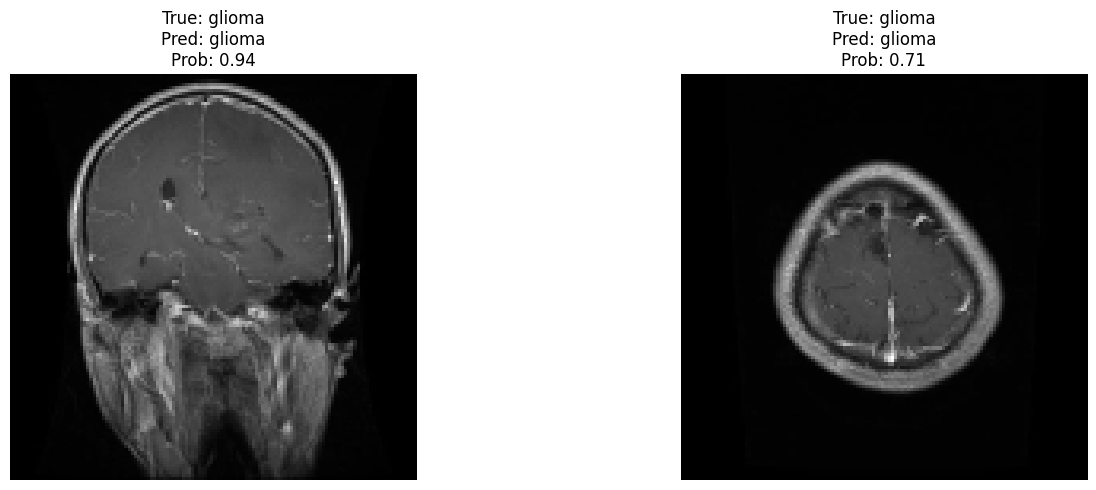

In [68]:
display_svm_predictions(model6, X_test, y_test, LABELS, num_images=2)